In [1]:
import pandas as pd
from time import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
import timeit
import time

from sklearn import model_selection
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
df = pd.read_csv("daily_BTC_USD.csv", parse_dates = ['Date'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606 entries, 0 to 3605
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3606 non-null   datetime64[ns]
 1   Open       3606 non-null   float64       
 2   High       3606 non-null   float64       
 3   Low        3606 non-null   float64       
 4   Close      3606 non-null   float64       
 5   Adj Close  3606 non-null   float64       
 6   Volume     3606 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 197.3 KB


In [4]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
df.shape

(3606, 7)

In [6]:
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,3606,3606.000000,3606.000000,3606.000000,3606.000000,3606.000000,3.606000e+03
mean,2019-08-24 11:59:59.999999744,17254.500027,17647.350132,16835.869013,17271.128832,17271.128832,1.742216e+10
min,2014-09-17 00:00:00,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,2017-03-06 06:00:00,1085.379974,1121.095032,1056.792480,1100.714996,1100.714996,2.645232e+08
50%,2019-08-24 12:00:00,8935.910157,9190.421387,8777.600098,8930.080078,8930.080078,1.352091e+10
75%,2022-02-10 18:00:00,28308.497559,28744.270020,27740.186523,28328.128418,28328.128418,2.811554e+10
max,2024-07-31 00:00:00,73079.375000,73750.070313,71334.093750,73083.500000,73083.500000,3.509679e+11
std,NaN,19150.178838,19580.307368,18679.962551,19162.392862,19162.392862,1.915652e+10


In [7]:
df.corr()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,1.000000,0.801180,0.799387,0.804119,0.801399,0.801399,0.627678
Open,0.801180,1.000000,0.999552,0.999256,0.998978,0.998978,0.645891
High,0.799387,0.999552,1.000000,0.999118,0.999558,0.999558,0.651569
Low,0.804119,0.999256,0.999118,1.000000,0.999455,0.999455,0.635678
Close,0.801399,0.998978,0.999558,0.999455,1.000000,1.000000,0.644600
Adj Close,0.801399,0.998978,0.999558,0.999455,1.000000,1.000000,0.644600
Volume,0.627678,0.645891,0.651569,0.635678,0.644600,0.644600,1.000000


In [8]:
df_Close = df['Close']
print(type(df_Close), df_Close.shape)

df_Close = df_Close.values.reshape(len(df_Close), 1)
print(type(df_Close), df_Close.shape)

# Training and test sets
length_train = int(.8*len(df_Close))
length_test = len(df_Close) - length_train
train = df_Close[:length_train]
test = df_Close[length_train: length_train+ length_test]

print(train.shape)
print(test.shape)


<class 'pandas.core.series.Series'> (3606,)
<class 'numpy.ndarray'> (3606, 1)
(2884, 1)
(722, 1)


In [9]:
# splitting training testing x y
def get_data(data, look_back):
  data_x, data_y = [],[]
  for i in range(len(data)-look_back-1):
    data_x.append(data[i:(i+look_back),0])
    data_y.append(data[i+look_back,0])
  return np.array(data_x) , np.array(data_y)

look_back = 3

x_train , y_train = get_data(train, look_back)

print(x_train.shape)
print(y_train.shape)
x_test , y_test = get_data(test,look_back)

print(x_test.shape)
print(y_test.shape)


(2880, 3)
(2880,)
(718, 3)
(718,)


In [10]:
print(x_test[0])
print(df['Date'][length_train])
print(df['Close'][length_train])

print(x_test[len(x_test) - 1])
print(df['Date'][length_train + length_test - 3])
print(df['Close'][length_train + length_test - 3])

print('\n')

print(y_test[0])
print(df['Date'][length_train + 1])
print(df['Close'][length_train + 1])

print(y_test[len(y_test)-1])
print(df['Date'][length_train + length_test - 2])
print(df['Close'][length_train + length_test - 2])

[23947.642578 23957.529297 24402.818359]
2022-08-10 00:00:00
23947.642578
[67813.335938 68255.867188 66819.914063]
2024-07-29 00:00:00
66819.914063


24424.068359
2022-08-11 00:00:00
23957.529297
66201.015625
2024-07-30 00:00:00
66201.015625


In [11]:
#Creating a dataframeimport datetime df_plotting which adds a Date column
import datetime
# start_date = pd.to_datetime("2017-06-01")
start_date = df['Date'][length_train+1]
num_days = len(y_test)

date_list = [start_date.date() + datetime.timedelta(days=x) for x in range(num_days)]
len(date_list)

df_plotting = pd.DataFrame()
df_plotting['Date'] = date_list

In [12]:
#Adding a column to the df_plotting dataframe store test data as column test_data

df_plotting['Actual'] = y_test.tolist()
df_plotting

,Date,Actual
0,2022-08-11,24424.068359
1,2022-08-12,24319.333984
2,2022-08-13,24136.972656
3,2022-08-14,23883.291016
4,2022-08-15,23335.998047
...,...,...
713,2024-07-24,67912.062500
714,2024-07-25,67813.335938
715,2024-07-26,68255.867188
716,2024-07-27,66819.914063


In [13]:
#changing the index of df_plotting
df_plotting.set_index('Date', inplace=True)

# Linear Regression

In [14]:
start = time.time()

model_LinearR = LinearRegression()
model_LinearR.fit(x_train, y_train) 
y_pred_LinearR= model_LinearR.predict(x_test)

end = time.time()
elapsed_time = (end - start)
print("Elapsed Time = " ,elapsed_time)

# add to the df_plotting dataframe
df_plotting['LR'] = y_pred_LinearR.tolist()

Elapsed Time =  0.010796785354614258


In [15]:
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix
#mean_squared_error(y_test, y_pred)

mean_absolute_error =  round( metrics.mean_absolute_error(y_test, y_pred_LinearR), 6)
mean_squared_error = round( metrics.mean_squared_error(y_test, y_pred_LinearR), 6)
root_mean_squared_error =  round( np.sqrt(metrics.mean_squared_error(y_test, y_pred_LinearR)), 6)

print('Mean Absolute Error:', mean_absolute_error)  
print('Mean Squared Error:', mean_squared_error)
print('Root Mean Squared Error:', root_mean_squared_error)


def mean_absolute_percentage_error(y_test, y_pred_LinearR): 
    y_test, y_pred_LinearR = np.array(y_test), np.array(y_pred_LinearR)
    return np.mean(np.abs((y_test - y_pred_LinearR) / y_test)) * 100

mean_absolute_percentage_error =  round( mean_absolute_percentage_error(y_test, y_pred_LinearR), 6)
variance_score = round( model_LinearR.score(x_test, y_test), 6)
r2_score = round(r2_score(y_test,y_pred_LinearR), 6)

print('Mean_absolute_percentage_error: ', mean_absolute_percentage_error)
print('Variance score: ', variance_score)
print("R2 score :" ,r2_score)

def mean_pairwise_distance(actual, predict):
  if len(actual) != len(predict):
    raise ValueError("Series lengths must be equal.")

  total_distance = 0
  for i in range(len(actual)):
    distance = abs(actual[i] - predict[i])
    total_distance += distance

  return total_distance / (len(actual) * (len(actual) - 1))

mean_pairwise_distance = round( mean_pairwise_distance(y_test, y_pred_LinearR), 5)
print("Mean Pairwise Distance: ", mean_pairwise_distance)

def smape(actual, predicted):
  numerator = 2 * np.abs(predicted - actual)
  denominator = np.abs(actual) + np.abs(predicted)

  # Handle division by zero for cases where both actual and predicted are zero
  mask = denominator != 0
  smape = np.mean(np.where(mask, numerator / denominator * 100, 0))

  return smape

Symmetric_Mean_Absolute_Percentage_Error = round( smape(y_test, y_pred_LinearR), 5)
print("Symmetric Mean Absolute Percentage Error: ",Symmetric_Mean_Absolute_Percentage_Error)

Mean Absolute Error: 652.649301
Mean Squared Error: 1146797.629787
Root Mean Squared Error: 1070.886376
Mean_absolute_percentage_error:  1.723837
Variance score:  0.996177
R2 score : 0.996177
Mean Pairwise Distance:  0.91025
Symmetric Mean Absolute Percentage Error:  1.72683


In [16]:
#adding measurement score to csv file
import csv

# Define the data for the row to modify
row_to_modify = 2  # Change this to the desired row number (starting from 1)
new_values = ["Close", elapsed_time, mean_absolute_error, mean_absolute_percentage_error, Symmetric_Mean_Absolute_Percentage_Error,
              mean_squared_error, root_mean_squared_error, mean_pairwise_distance,
              r2_score, variance_score]  # Replace with your actual values

# Open the CSV file in read mode
with open("measurement_values.csv", 'r') as csvfile:
  # Create a csv reader object
  csv_reader = csv.reader(csvfile)
  
  # Read all rows into a list
  data = list(csv_reader)

# Modify the data in the desired row
data[row_to_modify - 1] = new_values  # Adjust index for 0-based indexing

# Open a new file for writing
with open('measurement_values.csv', 'w', newline='') as csvfile:
  # Create a csv writer object
  csv_writer = csv.writer(csvfile)
  # Write the modified data to the new file
  csv_writer.writerows(data)


# Plotting

                  Actual            LR
Date                                  
2022-08-11  24424.068359  24386.211549
2022-08-12  24319.333984  24419.699991
2022-08-13  24136.972656  24316.452382
2022-08-14  23883.291016  24135.703254
2022-08-15  23335.998047  23883.761288
...                  ...           ...
2024-07-24  67912.062500  65710.582225
2024-07-25  67813.335938  67804.155738
2024-07-26  68255.867188  67767.818910
2024-07-27  66819.914063  68187.263102
2024-07-28  66201.015625  66801.610147

[718 rows x 2 columns]


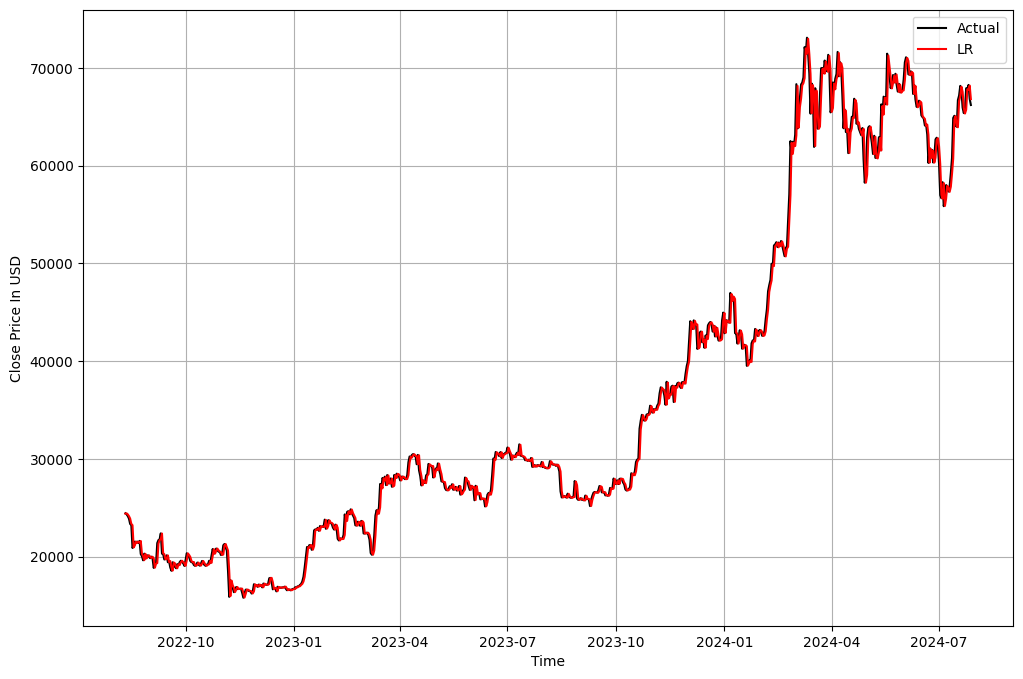

In [17]:
print(df_plotting)
plt.figure(figsize=(12,8))
plt.plot(df_plotting['Actual'] , label = 'Actual', color = 'black')
plt.plot(df_plotting['LR'] , label = 'LR', color = 'r')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Close Price In USD")
plt.grid()
plt.savefig("Close_LinearR_Final_Coding_Plot_Image")

In [18]:
import pickle

# Save the Ridge model to a file (pickle it)
with open('Close_LinearR.pkl', 'wb') as f:
    pickle.dump(model_LinearR, f)